In [169]:
# !pip install cvxopt
# !pip install cvxpy

In [170]:
import cplex
import csv
import numpy as np
import cvxpy as cp
import pandas as pd
import ipopt
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import math

### Estimation of parameters

In [171]:
stock_array = ['F.csv','CAT.csv','DIS.csv','MCD.csv','KO.csv','PEP.csv','WMT.csv','C.csv','WFC.csv','JPM.csv','AAPL.csv','IBM.csv','PFE.csv','JNJ.csv','XOM.csv','MRO.csv','ED.csv','T.csv','VZ.csv','NEM.csv']
stock_names = ['F','CAT','DIS','MCD','KO','PEP','WMT','C','WFC','JPM','AAPL','IBM','PFE','JNJ','XOM','MRO','ED','T','VZ','NEM']
init_data = np.empty((0, 48))

for stock in stock_array:
  with open(stock, newline='') as stock_csv:
    csv_read = csv.DictReader(stock_csv)
    stock_column = np.array([])
    for stock_row in csv_read:
      stock_column = np.append(stock_column,float(stock_row['Adj Close']))
  buffer = np.array([stock_column])
  init_data = np.append(init_data,buffer,axis=0)

data2 = np.empty((20, 45))

for i in range(0,20):
  for j in range(0,45):
    data2[i][j]=(init_data[i][j+1]-init_data[i][j])/init_data[i][j]

mu_val = np.mean(data2, axis=1)
stock_column = np.empty((20,20))

for i in range(0,20):
  for j in range(0,20):
    a = data2[i,:]
    b = data2[j,:]
    c = np.cov(a, b)
    stock_column[i][j] = c[0,1]

df_cov = pd.DataFrame(stock_column, columns=stock_names, index=stock_names)
rf_year = 0.04345
rf_month = rf_year/12
mkt_cap_array = [59.24,123.65,320.82,175.05,241.07,203.93,391.96,158.94,186.38,485.58,2100,134.51,227.71,439.99,265.65,10.62,26.41,208.35,237.39,56.93]

mu_october = []
for i in range(20):
    mu_october.append(init_data[i][-2]/init_data[i][-3]-1)
    
mu_november = []
for i in range(20):
    mu_november.append(init_data[i][-1]/init_data[i][-2]-1)
    
mkt_w = []
for i in range(20):
    mkt_w.append(mkt_cap_array[i]/sum(mkt_cap_array))
    
mu_cap_val = np.dot(np.array(mu_val),np.array(mkt_w))
var_cap_val = np.dot(np.array(mkt_w),(np.dot(stock_column,np.array(mkt_w))))
lambda_val = (mu_cap_val - rf_month)/var_cap_val

In [172]:
print('mean return:')
mu_val

mean return:


array([-2.47672167e-02,  2.05868694e-03,  1.43739778e-05,  1.63954745e-02,
        4.54341806e-03,  4.17431531e-03,  3.74537781e-03, -1.98470248e-02,
        7.82040636e-03,  7.83931502e-03,  3.15632257e-02,  3.08112537e-03,
       -1.94987945e-03,  1.40589894e-03,  1.14095581e-02,  1.66172102e-02,
        4.67715630e-03,  8.13844736e-03,  1.87990673e-03, -4.39309782e-03])

In [173]:
print('covariance matrix:')
df_cov

covariance matrix:


,F,CAT,DIS,MCD,KO,PEP,WMT,C,WFC,JPM,AAPL,IBM,PFE,JNJ,XOM,MRO,ED,T,VZ,NEM
F,0.021957,0.005966,0.003265,0.003193,0.002823,0.002279,0.002748,0.008763,0.003159,0.004948,0.002881,0.004677,0.001585,0.001856,0.002940,0.004385,0.001008,0.001640,0.002440,0.003682
CAT,0.005966,0.007163,0.002322,0.001826,0.001839,0.001650,0.000381,0.002927,-0.000239,0.000640,0.004730,0.002547,0.001178,0.000683,0.002172,0.005207,-0.000066,0.002225,0.002091,0.003900
DIS,0.003265,0.002322,0.002522,0.001118,0.001132,0.001054,0.000432,0.001672,-0.000248,0.000175,0.001547,0.001674,0.000220,0.000579,0.000379,0.001599,0.000023,0.001121,0.001182,0.000191
MCD,0.003193,0.001826,0.001118,0.002818,0.001361,0.000948,0.000268,0.001907,0.000525,0.001265,0.004143,0.001809,0.000684,0.000738,0.001310,0.001933,0.000730,0.001272,0.001285,0.000552
KO,0.002823,0.001839,0.001132,0.001361,0.001971,0.001550,0.000235,0.001880,0.000632,0.001276,0.001687,0.001323,0.000483,0.000967,0.000766,0.001436,0.000369,0.000926,0.000880,0.000581
PEP,0.002279,0.001650,0.001054,0.000948,0.001550,0.002249,0.000165,0.002044,0.000960,0.001426,0.001275,0.001069,0.000494,0.001194,0.000088,0.001036,0.000430,0.000641,0.000843,0.000354
WMT,0.002748,0.000381,0.000432,0.000268,0.000235,0.000165,0.002129,0.000844,0.000811,0.001184,-0.000468,0.000780,-0.000639,0.000448,-0.000701,-0.001506,-0.000180,-0.000023,0.000093,-0.000691
C,0.008763,0.002927,0.001672,0.001907,0.001880,0.002044,0.000844,0.008502,0.004235,0.004881,0.001344,0.002489,0.001428,0.001538,0.001015,0.001445,0.000940,0.001401,0.001691,0.001137
WFC,0.003159,-0.000239,-0.000248,0.000525,0.000632,0.000960,0.000811,0.004235,0.005671,0.004895,-0.002409,0.000970,0.001383,0.000734,-0.000925,-0.002014,0.000619,-0.000507,-0.000393,-0.000822
JPM,0.004948,0.000640,0.000175,0.001265,0.001276,0.001426,0.001184,0.004881,0.004895,0.005632,-0.000177,0.001196,0.001388,0.001028,-0.000309,-0.001447,0.000726,0.000332,0.000304,-0.000339


In [174]:
print('lambda value:', lambda_val)

lambda value: 3.032013739142709


### Model 1: Standard MVO

In [175]:
x_standardMVO = cp.Variable(20)
problem = cp.Problem(cp.Maximize(mu_val.T@x_standardMVO - lambda_val*cp.quad_form(x_standardMVO, stock_column)), [sum(x_standardMVO) == 1])
problem.solve()

0.05522328522933507

In [176]:
print ('optimal value:', problem.value)
print ('optimal weights:')
x_standardMVO.value

optimal value: 0.05522328522933507
optimal weights:


array([-0.06137239, -0.18503826,  0.87902741,  1.45966544, -0.98364027,
        0.9566449 ,  0.07124755, -1.6571645 ,  2.1640115 ,  0.42273401,
        0.21491488, -1.29861305, -1.78979265, -0.15861133,  0.94519397,
        0.58516598, -1.08359816,  1.01744536, -0.54920764,  0.05098727])

In [177]:
mu_standardMVO = np.array(mu_val)
w_standardMVO = x_standardMVO.value
ret_standardMVO = np.dot(mu_standardMVO, w_standardMVO)
var_standardMVO = np.dot (w_standardMVO,(np.dot(stock_column,w_standardMVO)))
std_standardMVO = np.sqrt(var_standardMVO)
sharpe_standardMVO = (ret_standardMVO - rf_month)/std_standardMVO

### Model 2: Robust MVO

In [178]:
theta_val = (np.sqrt(np.diag(np.diag(stock_column))))/np.sqrt(43)
cl_90, cl_95 = 1.645*theta_val, 1.96*theta_val

# 90% confidence level
x_robustMVO_90 = cp.Variable(20)
abs_robustMVO_90 = cp.abs(x_robustMVO_90)
problem = cp.Problem(cp.Maximize(mu_val.T@x_robustMVO_90 - lambda_val*cp.quad_form(x_robustMVO_90, stock_column)), [mu_val.T@x_robustMVO_90 - cl_90.T@abs_robustMVO_90 >= ret_standardMVO,sum(x_robustMVO_90) == 1])
problem.solve()

0.042885384982616945

In [179]:
print ('optimal value for 90% confidence level:', problem.value)
print ('optimal weights:')
x_robustMVO_90.value

optimal value for 90% confidence level: 0.042885384982616945
optimal weights:


array([-0.33656332, -0.30526143,  0.92131382,  2.39816404, -1.56803693,
        1.65528766,  0.4840912 , -1.72333276,  2.11010883,  1.01037026,
        0.24350173, -1.64825141, -2.30269604, -0.74786526,  1.38005997,
        0.94029251, -1.63054323,  1.38263139, -1.1922176 , -0.07105341])

In [180]:
# 95% confidence level
x_robustMVO_95 = cp.Variable(20)
abs_robustMVO_95 = cp.abs(x_robustMVO_95)
problem = cp.Problem(cp.Maximize(mu_val.T@x_robustMVO_95 - lambda_val*cp.quad_form(x_robustMVO_95, stock_column)), [mu_val.T@x_robustMVO_95 - cl_95.T@abs_robustMVO_95 >= ret_standardMVO,sum(x_robustMVO_95) == 1])
problem.solve()

0.03796243273205899

In [181]:
print ('optimal value for 95% confidence level:', problem.value)
print ('optimal weights:')
x_robustMVO_95.value

optimal value for 95% confidence level: 0.03796243273205899
optimal weights:


array([-0.44872301, -0.34243063,  0.83466465,  2.5690925 , -1.65126012,
        1.81891057,  0.6915785 , -1.50662219,  1.8445975 ,  1.124207  ,
        0.22561117, -1.61749974, -2.25197061, -0.97179111,  1.44820291,
        0.99556475, -1.68360804,  1.40020698, -1.36681584, -0.11191526])

In [182]:
w_robustMVO_90 = x_robustMVO_90.value
ret_robustMVO_90 = np.dot(mu_standardMVO, w_robustMVO_90)
var_robustMVO_90 = np.dot(w_robustMVO_90,(np.dot(stock_column,w_robustMVO_90)))
std_robustMVO_90 = np.sqrt(var_robustMVO_90)
sharpe_robustMVO_90 = (ret_robustMVO_90 - rf_month)/std_robustMVO_90

w_robustMVO_95 = x_robustMVO_95.value
ret_robustMVO_95 = np.dot(mu_standardMVO, w_robustMVO_95)
var_robustMVO_95 = np.dot(w_robustMVO_95,(np.dot(stock_column,w_robustMVO_95)))
std_robustMVO_95 = np.sqrt(var_robustMVO_95)
sharpe_robustMVO_95 = (ret_robustMVO_95 - rf_month)/std_robustMVO_95

### Model 3: Risk parity optimization with no short-selling

In [183]:
class riskParity(object):
    
    def __init__(self):
        pass

    def objective(self, x): # calculate objective function
        y = x * np.dot(stock_column, x)
        f = 0
        for i in range(20):
            for j in range(i,20):
                x_buffer = y[i] - y[j]
                f += x_buffer*x_buffer
        f = 2*f
        return f

    def gradient(self, x): # calculate gradient
        gradient_matrix = np.zeros(20)
        y = x * np.dot(stock_column,x)
        for i in range(20):
            for j in range(i,20):
                delta_1, delta_2 = stock_column[i].dot(x) + stock_column[i,i] * x[i], stock_column[i,j] * x[i]
                G = (y[i]-y[j]) * (delta_1 - delta_2)
                gradient_matrix[i] += G
            gradient_matrix[i] *= 4
        return gradient_matrix

    def constraints(self, x): # calculate constraints
        constraint_matrix = [1.0] * 20
        return constraint_matrix

    def jacobian(self, x): # calculate Jacobian matrix
        jacobian_matrix = np.array([[1.0] * 20])
        return jacobian_matrix

In [184]:
n = 20
w_initial, lb, ub, cl, cu = [1/n] * n, [0] * n, [1] * n, [1], [1]

nlp = ipopt.problem(n=len(w_initial), m=len(cl), problem_obj=riskParity(), lb=lb, ub=ub, cl=cl, cu=cu)
nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
nlp.addOption('tol'.encode('utf-8'), 1e-10)

w, dummyVar = nlp.solve(w_initial) # solving for the weights

In [185]:
w_riskParity = w/np.sum(w)
ret_riskParity = np.dot(mu_standardMVO,w_riskParity)
var_riskParity = np.dot(w_riskParity,(np.dot(stock_column,w_riskParity)))
std_riskParity = np.sqrt(var_riskParity)
sharpe_riskParity = (ret_riskParity-rf_month)/std_riskParity

In [186]:
print ('optimal weights for risk parity optimization with no short-selling:')
w_riskParity

optimal weights for risk parity optimization with no short-selling:


array([0.01448362, 0.02629311, 0.05523552, 0.04005757, 0.04790042,
       0.05155798, 0.12613948, 0.02288095, 0.05597793, 0.0362749 ,
       0.02315996, 0.03759066, 0.0641025 , 0.07050151, 0.05143452,
       0.02855864, 0.10397183, 0.04990735, 0.04961795, 0.04435361])

### Model 4: Market capitalization

In [187]:
w_mktCap = np.array(mkt_w)
ret_mktCap = mu_cap_val
var_mktCap = var_cap_val
std_mktCap = np.sqrt(var_mktCap)
sharpe_mktCap = (ret_mktCap-rf_month)/std_mktCap

In [188]:
print ('normalized weights for market capitalization:')
w_mktCap

normalized weights for market capitalization:


array([0.00978498, 0.02042391, 0.05299149, 0.02891391, 0.03981877,
       0.03368417, 0.06474205, 0.02625294, 0.03078534, 0.08020574,
       0.34686778, 0.02221771, 0.03761203, 0.07267541, 0.04387877,
       0.00175416, 0.00436228, 0.03441424, 0.03921093, 0.00940342])

### Question A

In [189]:
# using model 1 (standard MVO)

ret_standardMVO_oct = np.dot(np.array(1), w_standardMVO)
var_standardMVO_oct = np.dot(w_standardMVO, np.dot(stock_column,w_standardMVO))
std_standardMVO_oct = np.sqrt(var_standardMVO_oct)
sharpe_standardMVO_oct = (ret_standardMVO_oct - rf_month)/std_standardMVO_oct

print('Using standard MVO:')
print('Return for October 2008 =', ret_standardMVO_oct)
print('Variance for October 2008 =', var_standardMVO_oct)
print('Standard deviation for October 2008 =', std_standardMVO_oct)
print('Sharpe Ratio for October 2008 =', sharpe_standardMVO_oct)

Using standard MVO:
Return for October 2008 = [-0.06137239 -0.18503826  0.87902741  1.45966544 -0.98364027  0.9566449
  0.07124755 -1.6571645   2.1640115   0.42273401  0.21491488 -1.29861305
 -1.78979265 -0.15861133  0.94519397  0.58516598 -1.08359816  1.01744536
 -0.54920764  0.05098727]
Variance for October 2008 = 0.016916682902129988
Standard deviation for October 2008 = 0.13006414918081766
Sharpe Ratio for October 2008 = [ -0.49970132  -1.45050805   6.73057552  11.19481897  -7.59057061
   7.32733861   0.51994893 -12.76897088  16.61019332   3.22235741
   1.62453715 -10.0122431  -13.78868421  -1.2473242    7.239298
   4.47121784  -8.35909819   7.79480379  -4.25042929   0.36417752]


In [190]:
# using model 2 (robust MVO)

# 90% confidence level
ret_robustMVO_90_oct = np.dot(np.array(mu_october), w_robustMVO_90)
var_robustMVO_90_oct = np.dot(w_robustMVO_90, np.dot(stock_column,w_robustMVO_90))
std_robustMVO_90_oct = np.sqrt(var_robustMVO_90_oct)
sharpe_robustMVO_90_oct = (ret_robustMVO_90_oct - rf_month)/std_robustMVO_90_oct

# 95% confidence level
ret_robustMVO_95_oct = np.dot(np.array(mu_october), w_robustMVO_95)
var_robustMVO_95_oct = np.dot(w_robustMVO_95, np.dot(stock_column,w_robustMVO_95))
std_robustMVO_95_oct = np.sqrt(var_robustMVO_95_oct)
sharpe_robustMVO_95_oct = (ret_robustMVO_95_oct - rf_month)/std_robustMVO_95_oct

print('Using robust MVO:')
print('Return for October 2008 (90% CL) =', ret_robustMVO_90_oct)
print('Return for October 2008 (95% CL) =', ret_robustMVO_95_oct)
print('Variance for October 2008 (90% CL) =', var_robustMVO_90_oct)
print('Variance for October 2008 (95% CL) =', var_robustMVO_95_oct)
print('Standard deviation for October 2008 (90% CL) =', std_robustMVO_90_oct)
print('Standard deviation for October 2008 (95% CL) =', std_robustMVO_95_oct)
print('Sharpe Ratio for October 2008 (90% CL) =', sharpe_robustMVO_90_oct)
print('Sharpe Ratio for October 2008 (95% CL) =', sharpe_robustMVO_95_oct)

Using robust MVO:
Return for October 2008 (90% CL) = 0.2685947640335115
Return for October 2008 (95% CL) = 0.15689180695145954
Variance for October 2008 (90% CL) = 0.03413310565198897
Variance for October 2008 (95% CL) = 0.036303574885277023
Standard deviation for October 2008 (90% CL) = 0.18475146995893962
Standard deviation for October 2008 (95% CL) = 0.1905349702424125
Sharpe Ratio for October 2008 (90% CL) = 1.4342182541717676
Sharpe Ratio for October 2008 (95% CL) = 0.8044243711436473


In [191]:
# using model 3 (risk parity optimization with no short-selling)

ret_riskParity_oct = np.dot(np.array(mu_october), w_riskParity)
var_riskParity_oct = np.dot(w_riskParity, np.dot(stock_column,w_riskParity))
std_riskParity_oct = np.sqrt(var_riskParity_oct)
sharpe_riskParity_oct = (ret_riskParity_oct - rf_month)/std_riskParity_oct

print('Using risk parity optimization with no short-selling:')
print('Return for October 2008 =', ret_riskParity_oct)
print('Variance for October 2008 =', var_riskParity_oct)
print('Standard deviation for October 2008 =', std_riskParity_oct)
print('Sharpe Ratio for October 2008 =', sharpe_riskParity_oct)

Using risk parity optimization with no short-selling:
Return for October 2008 = -0.022701204942354853
Variance for October 2008 = 0.0009151974679887562
Standard deviation for October 2008 = 0.030252230793592003
Sharpe Ratio for October 2008 = -0.8700858609495897


In [192]:
# using model 4 (market capitalization)

ret_mktCap_oct = np.dot(np.array(mu_october), w_mktCap)
var_mktCap_oct = np.dot(w_mktCap, np.dot(stock_column,w_mktCap))
std_mktCap_oct = np.sqrt(var_mktCap_oct)
sharpe_mktCap_oct = (ret_mktCap_oct - rf_month)/std_mktCap_oct

print('Using market capitalization:')
print('Return for October 2008 =', ret_mktCap_oct)
print('Variance for October 2008 =', var_mktCap_oct)
print('Standard deviation for October 2008 =', std_mktCap_oct)
print('Sharpe Ratio for October 2008 =', sharpe_mktCap_oct)

Using market capitalization:
Return for October 2008 = -0.07666716076850223
Variance for October 2008 = 0.0031247839094572256
Standard deviation for October 2008 = 0.05589976663150952
Sharpe Ratio for October 2008 = -1.4362849603844128


### Question B

In [193]:
# using Model 1 (standard MVO)

ret_standardMVO_nov = np.dot(np.array(mu_november), w_standardMVO)
var_standardMVO_nov = np.dot(w_standardMVO, np.dot(stock_column,w_standardMVO))
std_standardMVO_nov = np.sqrt(var_standardMVO)
sharpe_standardMVO_nov = (ret_standardMVO_nov - rf_month)/std_standardMVO

print('Using standard MVO:')
print('Return for November 2008 =', ret_standardMVO_nov)
print('Variance for November 2008 =', var_standardMVO_nov)
print('Standard deviation for November 2008 =', std_standardMVO_nov)
print('Sharpe Ratio for November 2008 =', sharpe_standardMVO_nov)

Using standard MVO:
Return for November 2008 = 0.273479778228532
Variance for November 2008 = 0.016916682902129988
Standard deviation for November 2008 = 0.13006414918081766
Sharpe Ratio for November 2008 = 2.0748142097176645


In [194]:
# using Model 2 (robust MVO)

# 90% confidence level
ret_robustMVO_90_nov = np.dot(np.array(mu_november), w_robustMVO_90)
var_robustMVO_90_nov = np.dot(w_robustMVO_90, np.dot(stock_column,w_robustMVO_90))
std_robustMVO_90_nov = np.sqrt(var_robustMVO_90_nov)
sharpe_robustMVO_90_nov = (ret_robustMVO_90_nov - rf_month)/std_robustMVO_90_nov

# 95% confidence level
ret_robustMVO_95_nov = np.dot(np.array(mu_november), w_robustMVO_95)
var_robustMVO_95_nov = np.dot(w_robustMVO_95, np.dot(stock_column,w_robustMVO_95))
std_robustMVO_95_nov = np.sqrt(var_robustMVO_95_nov)
sharpe_robustMVO_95_nov = (ret_robustMVO_95_nov - rf_month)/std_robustMVO_95_nov

print('Using robust MVO:')
print('Return for November 2008 (90% CL) =', ret_robustMVO_90_nov)
print('Return for November 2008 (95% CL) =', ret_robustMVO_95_nov)
print('Variance for November 2008 (90% CL) =', var_robustMVO_90_nov)
print('Variance for November 2008 (95% CL) =', var_robustMVO_95_nov)
print('Standard deviation for November 2008 (90% CL) =', std_robustMVO_90_nov)
print('Standard deviation for November 2008 (95% CL) =', std_robustMVO_95_nov)
print('Sharpe Ratio for November 2008 (90% CL) =', sharpe_robustMVO_90_nov)
print('Sharpe Ratio for November 2008 (95% CL) =', sharpe_robustMVO_95_nov)

Using robust MVO:
Return for November 2008 (90% CL) = 0.26794248638057977
Return for November 2008 (95% CL) = 0.2295049167911477
Variance for November 2008 (90% CL) = 0.03413310565198897
Variance for November 2008 (95% CL) = 0.036303574885277023
Standard deviation for November 2008 (90% CL) = 0.18475146995893962
Standard deviation for November 2008 (95% CL) = 0.1905349702424125
Sharpe Ratio for November 2008 (90% CL) = 1.4306876860356834
Sharpe Ratio for November 2008 (95% CL) = 1.185525592338394


In [195]:
# using model 3 (risk parity optimization with no short-selling)

ret_riskParity_nov = np.dot(np.array(mu_november), w_riskParity)
var_riskParity_nov = np.dot(w_riskParity, np.dot(stock_column,w_riskParity))
std_riskParity_nov = np.sqrt(var_riskParity_nov)
sharpe_riskParity_nov = (ret_riskParity_nov - rf_month)/std_riskParity_nov

print('Using risk parity optimization with no short-selling:')
print('Return for November 2008 =', ret_riskParity_nov)
print('Variance for November 2008 =', var_riskParity_nov)
print('Standard deviation for November 2008 =', std_riskParity_nov)
print('Sharpe Ratio for November 2008 =', sharpe_riskParity_nov)

Using risk parity optimization with no short-selling:
Return for November 2008 = 0.016216964569248263
Variance for November 2008 = 0.0009151974679887562
Standard deviation for November 2008 = 0.030252230793592003
Sharpe Ratio for November 2008 = 0.4163703272613876


In [196]:
# using model 4 (market capitalization)

ret_mktCap_nov = np.dot(np.array(mu_november), w_mktCap)
var_mktCap_nov = np.dot(w_mktCap, np.dot(stock_column,w_mktCap))
std_mktCap_nov = np.sqrt(var_mktCap_nov)
sharpe_mktCap_nov = (ret_mktCap_nov - rf_month)/std_mktCap_nov

print('Using market capitalization:')
print('Return for November 2008 =', ret_mktCap_nov)
print('Variance for November 2008 =', var_mktCap_nov)
print('Standard deviation for November 2008 =', std_mktCap_nov)
print('Sharpe Ratio for November 2008 =', sharpe_mktCap_nov)

Using market capitalization:
Return for November 2008 = -0.020910651885338048
Variance for November 2008 = 0.0031247839094572256
Standard deviation for November 2008 = 0.05589976663150952
Sharpe Ratio for November 2008 = -0.4388477215009248


### Question C

In [197]:
# estimated MVO frontier

ret_front1 = []
std_front1 = []

lambda_temp = 0.2
for l in range(250):
    lambda_temp = lambda_temp + 0.2
    x1 = cp.Variable(20)
    problem1 = cp.Problem(cp.Maximize(mu_val.T@x1 - lambda_temp*cp.quad_form(x1, stock_column)),
                          [sum(x1) == 1])
    problem1.solve()
    w1 = x1.value  
    ret_front1.append(float(np.dot(np.array(mu_october), w1)))
    std_front1.append(float(np.dot(w1, np.dot(stock_column,w1))))

In [198]:
# true MVO frontier

ret_front2 = []
std_front2 = []

lambda_temp = 0.2
for l in range(250):
    lambda_temp = lambda_temp + 0.2
    x1 = cp.Variable(20)
    problem1 = cp.Problem(cp.Maximize(mu_val.T@x1 - lambda_temp*cp.quad_form(x1, stock_column)),
                          [sum(x1) == 1])
    problem1.solve()
    w1 = x1.value  
    ret_front2.append(float(np.dot(np.array(mu_val), w1)))
    std_front2.append(float(np.dot(w1, np.dot(stock_column,w1))))

In [199]:
# actual MVO frontier

ret_front3 = []
std_front3 = []

lambda_temp = 0.2
for l in range(250):
    lambda_temp = lambda_temp + 0.2
    x1 = cp.Variable(20)
    problem1 = cp.Problem(cp.Maximize(mu_val.T@x1 - lambda_temp*cp.quad_form(x1, stock_column)),
                          [sum(x1) == 1])
    problem1.solve()
    w1 = x1.value  
    ret_front3.append(float(np.dot(np.array(mu_val+cl_90[0][0]), w1)))
    std_front3.append(float(np.dot(w1, np.dot(stock_column,w1))))

In [200]:
# actual robust frontier (90% CL)

ret_front4 = []
std_front4 = []

lambda_temp = 0.2
for l in range(250):
    lambda_temp = lambda_temp + 0.2
    x1 = cp.Variable(20)
    problem1 = cp.Problem(cp.Maximize(mu_val.T@x1 - lambda_temp*cp.quad_form(x1, stock_column)),
                          [mu_val.T@x1 - cl_90.T@abs_robustMVO_90 >= ret_standardMVO,sum(x1) == 1])
    problem1.solve()
    w1 = x1.value  
    ret_front4.append(float(np.dot(np.array(mu_val+cl_90[1][1]), w1)))
    std_front4.append(float(np.dot(w1, np.dot(stock_column,w1))))

In [201]:
# actual robust frontier (95% CL)

ret_front5 = []
std_front5 = []

lambda_temp = 0.2
for l in range(250):
    lambda_temp = lambda_temp + 0.2
    x1 = cp.Variable(20)
    problem1 = cp.Problem(cp.Maximize(mu_val.T@x1 - lambda_temp*cp.quad_form(x1, stock_column)),
                          [mu_val.T@x1 - cl_95.T@abs_robustMVO_95 >= ret_standardMVO,sum(x1) == 1])
    problem1.solve()
    w1 = x1.value  
    ret_front5.append(float(np.dot(np.array(mu_val+cl_95[0][0]), w1)))
    std_front5.append(float(np.dot(w1, np.dot(stock_column,w1))))

In [202]:
# estimated robust frontier (90% CL)

ret_front6 = []
std_front6 = []

lambda_temp = 0.2
for l in range(250):
    lambda_temp = lambda_temp + 0.2
    x1 = cp.Variable(20)
    problem1 = cp.Problem(cp.Maximize(mu_val.T@x1 - lambda_temp*cp.quad_form(x1, stock_column)),
                          [mu_val.T@x1 - cl_90.T@abs_robustMVO_90 >= ret_standardMVO,sum(x1) == 1])
    problem1.solve()
    w1 = x1.value  
    ret_front6.append(float(np.dot(np.array(mu_october+cl_90[0][0]), w1)))
    std_front6.append(float(np.dot(w1, np.dot(stock_column,w1))))

In [203]:
# estimated robust frontier (95% CL)

ret_front7 = []
std_front7 = []

lambda_temp = 0.2
for l in range(250):
    lambda_temp = lambda_temp + 0.2
    x1 = cp.Variable(20)
    problem1 = cp.Problem(cp.Maximize(mu_val.T@x1 - lambda_temp*cp.quad_form(x1, stock_column)),
                          [mu_val.T@x1 - cl_95.T@abs_robustMVO_95 >= ret_standardMVO,sum(x1) == 1])
    problem1.solve()
    w1 = x1.value  
    ret_front7.append(float(np.dot(np.array(mu_october+cl_95[0][0]), w1)))
    std_front7.append(float(np.dot(w1, np.dot(stock_column,w1))))

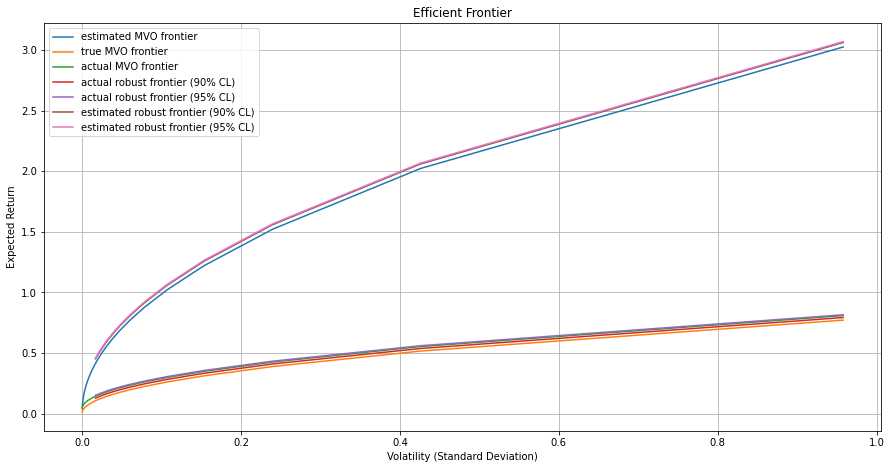

In [204]:
# efficient frontier plot

ax = plt.gca()
plt.rcParams['figure.figsize'] = [15, 7.5]
ax.plot(std_front1, ret_front1, label='estimated MVO frontier')
ax.plot(std_front2, ret_front2, label='true MVO frontier')
ax.plot(std_front3, ret_front3, label='actual MVO frontier')
ax.plot(std_front4, ret_front4, label='actual robust frontier (90% CL)')
ax.plot(std_front5, ret_front5, label='actual robust frontier (95% CL)')
ax.plot(std_front6, ret_front6, label='estimated robust frontier (90% CL)')
ax.plot(std_front7, ret_front7, label='estimated robust frontier (95% CL)')

ax.set_xlabel('Volatility (Standard Deviation)')
ax.set_ylabel('Expected Return')
plt.title('Efficient Frontier')
ax.legend()
ax.grid()
plt.show()